In [1]:
"""
 logscale : 
           
 create   : 2019/10/17
 modified : 2019/10/19
"""

'\n logscale : \n           \n create   : 2019/10/17\n modified : 2019/10/19\n'

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
def rgb2gray(rgb):
    return np.dot(rgb[..., :3], [0.2989, 0.5870, 0.1140])

In [20]:
# convolution 2D
def conv2d(img, kernel, padding='same'):
    # Error handling
    if kernel.shape[0] != kernel.shape[1]:
        print("Use square filter!")
        return None
    
    if kernel.shape[0]%2 == 0 and kernel.shape[1]%2 == 0:
        print("filter size has to be odd")
        return None
    
    # Create result matrix
    result = np.zeros_like(img)
    
    # Calculate kernel size
    kernel_size = kernel.shape[0]
    
    # same padding
    if padding=='same':
        pad_size = int((kernel_size - 1) / 2)
    else:
        pad_size = 0
    img = np.pad(img, pad_size, mode='constant')
    
    # convolution
    width, height = img.shape
    offset = int(kernel_size / 2)
    for x in range(offset, width-offset):
        for y in range(offset, height-offset):
            result[x-offset, y-offset] = np.sum(img[x-offset:x+offset+1, y-offset:y+offset+1] * kernel)
            
    return result

In [5]:
def LoG(sigma=1, stencil=19, verbose=False):
    """
        Parameters:
            1. sigma : the width of the Gaussian kernel
            2. stencil : the overall image size of the filter (default 19x19)
            
        Return:
            1. a numpy array with the filter values
    """
    # Using matrix operation (faster)
    basis = (np.arange(stencil)) - stencil//2
    x, y = np.meshgrid(basis, basis)
    
    tmp = (x**2 + y**2) / (2*(sigma**2))
    LoGfilter = -(1/(np.pi*(sigma**4))) * (1 - tmp) * np.exp(-tmp)
    if verbose:
        plt.title("sigma : %d, stencil size : %dpixel, LoGfilter shape : (%d,%d)\n" 
              %(sigma, stencil, LoGfilter.shape[0], LoGfilter.shape[1]))
        plt.imshow(LoGfilter, cmap='gray')

    return LoGfilter

In [6]:
def filterImg(img, fil):
    """
        Paramters:
            1. img : input image
            2. fil : filter
            
        Return:
            1. the filtered image
    """
    return conv2d(img.copy(), fil, padding="same")

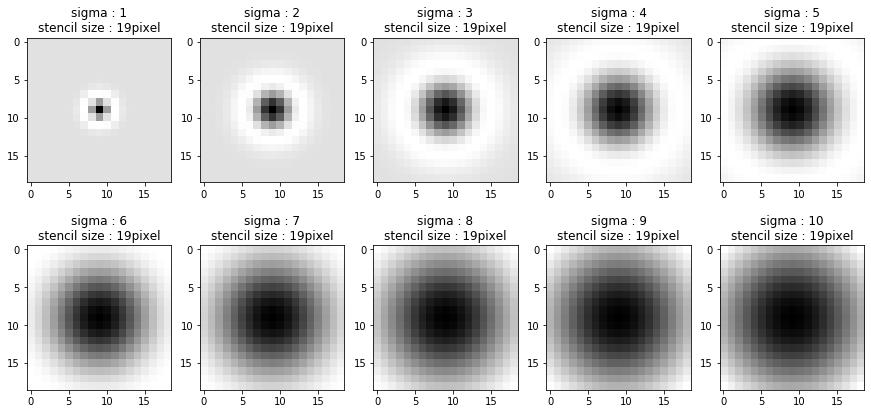

In [7]:
# Log filters
sigmas = [sigma+1 for sigma in range(10)]
fig = plt.figure(figsize= (15,7))
stencil = 19
for sigma in sigmas:
    LoG_filter = LoG(sigma=sigma, stencil=stencil)
    ax = fig.add_subplot(2, 5, sigma)
    ax.imshow(LoG_filter, cmap='gray')
    ax.set_title("sigma : %d\nstencil size : %dpixel" %(sigma, stencil))

(506, 900, 3)

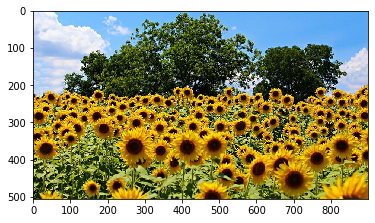

In [8]:
# read image
img = mpl.image.imread("sunflower.jpg")
plt.imshow(img)
img.shape

(506, 900)

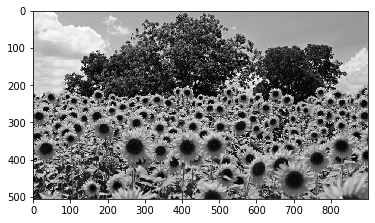

In [9]:
# read image
img = mpl.image.imread("sunflower.jpg")
img = rgb2gray(img)
plt.imshow(img, cmap='gray')
img.shape

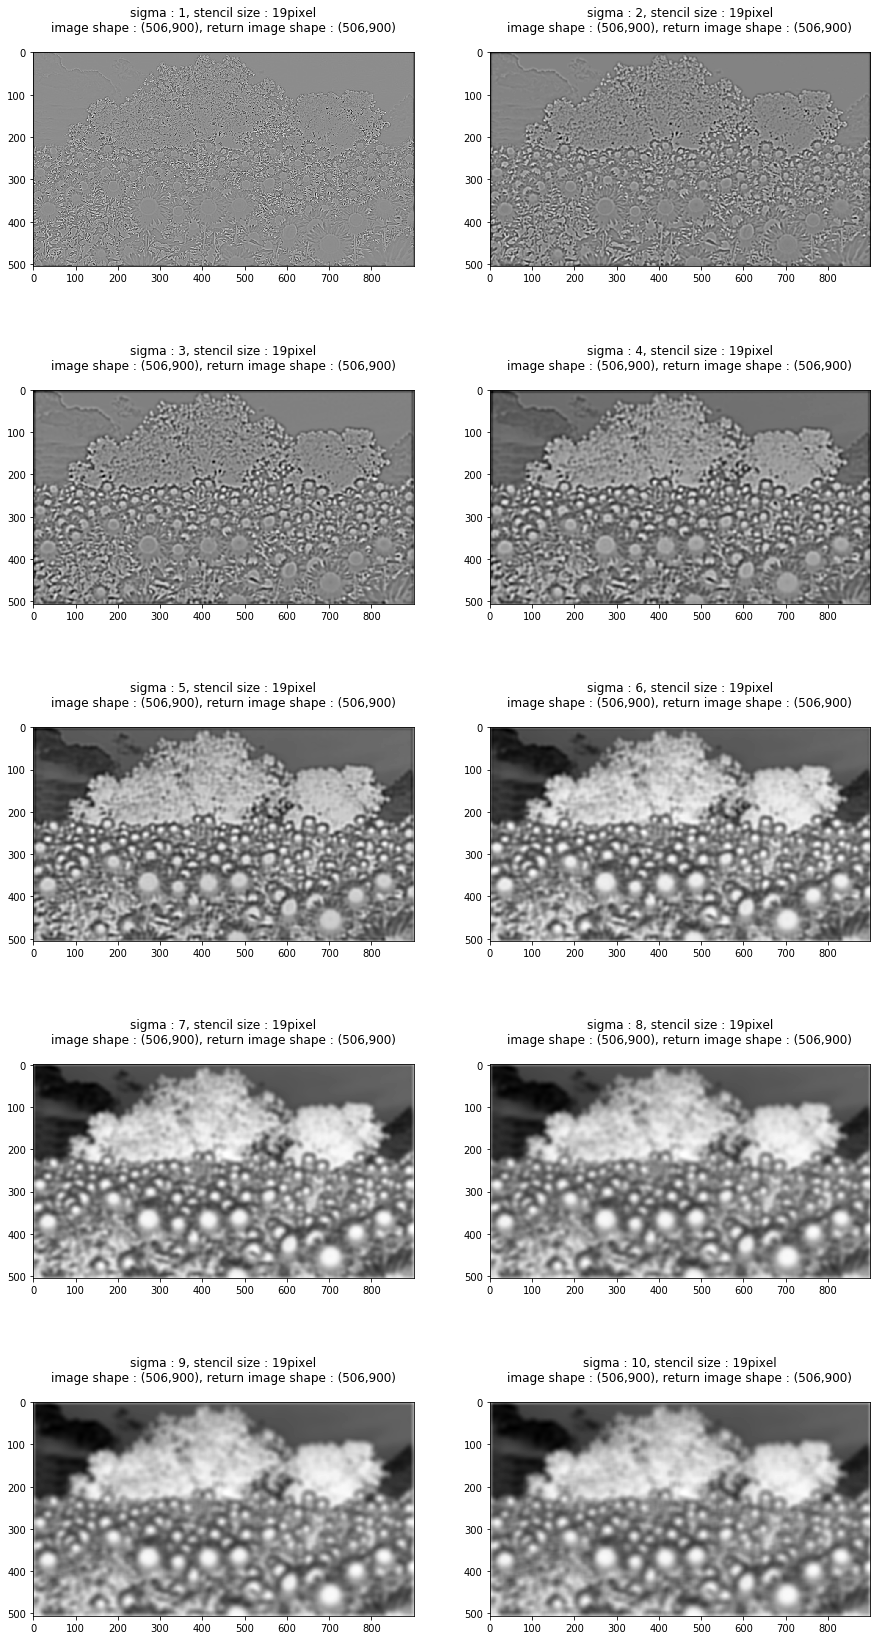

In [21]:
# Log filters
sigmas = [sigma+1 for sigma in range(10)]
fig = plt.figure(figsize= (15,30))
for sigma in sigmas:
    LoG_filter = LoG(sigma=sigma,stencil=stencil)
    returnImg = filterImg(img, LoG_filter)
    ax = fig.add_subplot(5, 2, sigma)
    ax.imshow(returnImg, cmap='gray')
    ax.set_title("sigma : %d, stencil size : %dpixel\nimage shape : (%d,%d), return image shape : (%d,%d)\n" 
                 %(sigma,stencil,img.shape[0],img.shape[1], returnImg.shape[0],returnImg.shape[1]))

In [143]:
def trackScale(colorImg, sigmas, stencil, threshold, verbose=False):
    if verbose:
        print('input argument => sigmas :{}, stencil : {}, threshold : {}\n' .format(sigmas, stencil, threshold))
    
    img = rgb2gray(colorImg)
    # 1. Create LoG filters
    LoG_filters = [LoG(sigma=sigma,stencil=stencil,verbose=verbose) for sigma in sigmas]
    
    # 2. Filters img with each LoG filter
    filtered_img = []
    sequence = zip(LoG_filters, sigmas)
    for idx, (LoG_filter, sigma) in enumerate(sequence):
        filtered_img.append(filterImg(img, LoG_filter))        
        
    # 3. For each pixel in the stack of filtered images, finds the maximum value
    totScale = np.max(np.array(filtered_img), axis=0)
    scale_idx = np.argmax(np.array(filtered_img), axis=0)
    if verbose:
        print('filtered_img.shape : {}, totScale.shape : {}, scale_idx.shape : {}, scale_idx:{}\n' 
              .format(np.array(filtered_img).shape,totScale.shape,scale_idx.shape, scale_idx[0][0]))
        print(totScale)
    
    # Plots the input picture img with overlays of the scaled blobs
    fig, ax = plt.subplots()
    ax.imshow(colorImg)
    
    width, height = img.shape
    for x in range(width):
        for y in range(height):
            if totScale[x][y] > threshold:
                circle = mpl.patches.Circle((y,x), radius=5, color='red', fill=False)
                ax.add_patch(circle)
                
    plt.show()

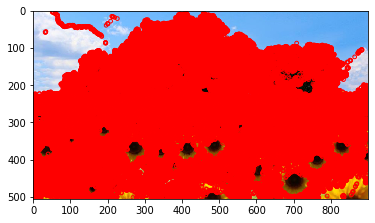

In [144]:
# read image
img = mpl.image.imread("sunflower.jpg")
sigmas = [sigma+1 for sigma in range(10)]
stencil = 19
threshold = 10
trackScale(img, sigmas, stencil, threshold, verbose=False)

input argument => sigmas :[9], stencil : 19, threshold : 20

filtered_img.shape : (1, 506, 900), totScale.shape : (506, 900), scale_idx.shape : (506, 900), scale_idx:0

[[-0.58431207 -0.66764737 -0.74775396 ... -0.47995575 -0.4290392
  -0.3760286 ]
 [-0.66606863 -0.76055259 -0.85139272 ... -0.54727011 -0.48935384
  -0.42907842]
 [-0.74425854 -0.84940214 -0.95049925 ... -0.61204271 -0.54738727
  -0.48011029]
 ...
 [-0.16274245 -0.18263683 -0.20072554 ... -0.39536161 -0.35670662
  -0.31544696]
 [-0.14614942 -0.16401458 -0.18038119 ... -0.35341997 -0.31883204
  -0.28188786]
 [-0.13026259 -0.1462214  -0.16086809 ... -0.30980427 -0.27942292
  -0.24694481]]


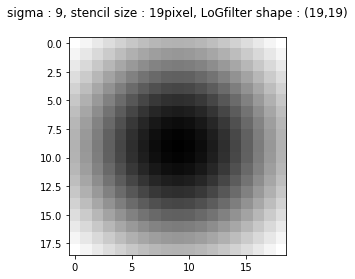

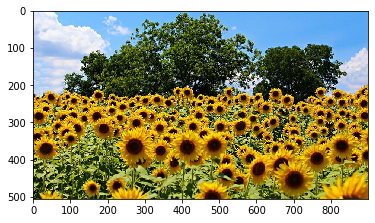

In [145]:
sigmas = [9]
threshold = 20
trackScale(img, sigmas, stencil, threshold, verbose=True)